# ASX Index predict and forecast using Stacked LSTM Model

In [1]:
import numpy as np
import pandas as pd
import math
import warnings
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [3]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [4]:
# ASX data
df = pd.read_csv('AXJO.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-25,6793.100098,6857.299805,6792.100098,6834.000000,6834.000000,806700.0
2021-02-26,6792.600098,6793.899902,6658.899902,6673.299805,6673.299805,1032700.0
2021-03-01,6673.299805,6790.100098,6672.200195,6789.600098,6789.600098,734300.0
2021-03-02,6789.600098,6860.700195,6762.299805,6762.299805,6762.299805,739300.0
2021-03-03,6762.299805,6818.799805,6762.299805,6818.000000,6818.000000,0.0


In [5]:
df.shape

(1266, 6)

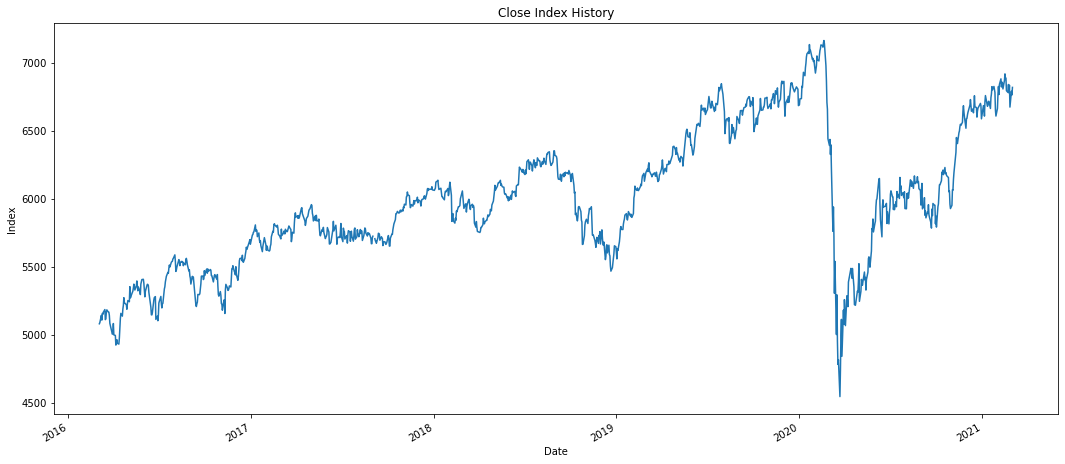

In [6]:
plt.figure(figsize=(18, 8)) # resizing the plot
df['Close'].plot()
plt.title('Close Index History') # adding a title
plt.xlabel('Date') # x label
plt.ylabel('Index') # y label
plt.show()

<Figure size 1152x576 with 0 Axes>

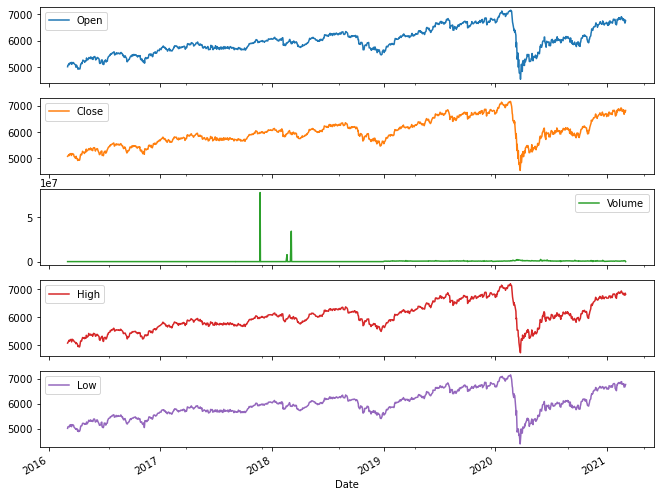

In [10]:
plt.figure(figsize=(16, 8)) # resizing the plot
cols = ['Open', 'Close', 'Volume', 'High', 'Low']
axes = df[cols].plot(figsize=(11, 9), subplots = True)
plt.show()

In [11]:
df_Price = df[['Close']]
df_Price.describe()

,Close
count,1265.000000
mean,5988.279291
std,490.438643
min,4546.000000
25%,5682.100098
50%,5942.600098
75%,6280.200195
max,7162.500000


In [12]:
df_Price.dropna(inplace=True)
df_Price.isnull().sum()

Close    0
dtype: int64

In [13]:
df_Price.shape

(1265, 1)

In [14]:
# LSTM is very sensitive to the scale of the data so we apply MinMax scalar

scaler = MinMaxScaler(feature_range=(0,1)) # scale down between 0,1 
df_Price_scaled = scaler.fit_transform(np.array(df_Price).reshape(-1,1)) # reshape to fit and transform

In [15]:
df_Price_scaled # df_Price_scaled is now converted into array and the values are in between 0 and 1

array([[0.20450988],
       [0.20791133],
       [0.22809089],
       ...,
       [0.85748141],
       [0.84704751],
       [0.86833556]])

In [16]:
# For Timeseries we need to split the dataset into train dataset and test dataset
# 70% of initial data is for training data
# Rest 30% data is for testing
# After doing this division we will able to do the data reprocess

train_size = int(len(df_Price_scaled) * .70) 
test_size = len(df_Price_scaled) - train_size
train_size, test_size

(885, 380)

In [17]:
# train_data starts from 0 to train_size which is 885 and the rest is for test_data
train_data, test_data = df_Price_scaled[0 : train_size, :], df_Price_scaled[train_size:len(df_Price_scaled), : 1]
len(train_data), len(test_data)

(885, 380)

In [18]:
train_data[:5], test_data[:5]

(array([[0.20450988],
        [0.20791133],
        [0.22809089],
        [0.21479075],
        [0.23359457]]),
 array([[0.76705523],
        [0.79006314],
        [0.80309566],
        [0.80336327],
        [0.79040707]]))

In [19]:
# convert array values into dataset matrix
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i : (i+time_step), 0] # iteration starts from 0 to time step
        dataX.append(a) # iteration value of time step 
        dataY.append(dataset[i + time_step, 0]) # the next value from time step
        
    return numpy.array(dataX), numpy.array(dataY)


In [20]:
# reshape into X=t, t+1, t+2, t+3 and then y=t+4

time_step =100 #time step is actually the days, here we are taking 100 days of index

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train.shape, y_train.shape

((784, 100), (784,))

In [21]:
# Before Stacked LSTM we have to reshape X_train into 3D. [samples, time step, feature] samples = X_train, time_steps=days and the 3rd one is features.

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # [0]=784, [1]=100, and the third 1 is the feature
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# We are using Sequential model
# We are using hidden layer 50
model=Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(100, 1))) # first input shape is X_train.shape[1], 1.
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1)) # final output

model.compile(loss='mean_squared_error', optimizer='adam')


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
# after model compile we fit the model using x_train, y_train with epoch 130, validation data is X_test and y_test 
model.fit(X_train, y_train, epochs=130, batch_size=64, validation_data=(X_test,y_test), verbose=1, shuffle=False)

Epoch 1/130
13/13 [==============================] - 5s 162ms/step - loss: 0.0562 - val_loss: 0.0274
Epoch 2/130
13/13 [==============================] - 1s 76ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch 3/130
13/13 [==============================] - 1s 76ms/step - loss: 0.0045 - val_loss: 0.0175
Epoch 4/130
13/13 [==============================] - 1s 76ms/step - loss: 0.0061 - val_loss: 0.0166
Epoch 5/130
13/13 [==============================] - 1s 76ms/step - loss: 0.0047 - val_loss: 0.0163
Epoch 6/130
13/13 [==============================] - 1s 76ms/step - loss: 0.0031 - val_loss: 0.0164
Epoch 7/130
13/13 [==============================] - 1s 76ms/step - loss: 0.0020 - val_loss: 0.0164
Epoch 8/130
13/13 [==============================] - 1s 76ms/step - loss: 0.0016 - val_loss: 0.0160
Epoch 9/130
13/13 [==============================] - 1s 77ms/step - loss: 0.0014 - val_loss: 0.0155
Epoch 10/130
13/13 [==============================] - 1s 76ms/step - loss: 0.0014 - val_loss: 0.015

In [26]:
# Predict and check performance metrics
# Predict X_train and X_test

training_data_predict = model.predict(X_train)
test_data_predict = model.predict(X_test)

In [27]:
# Transformback to original form of scaler - reverse scaling

training_data_predict = scaler.inverse_transform(training_data_predict)
test_data_predict = scaler.inverse_transform(test_data_predict)

In [28]:
# calculate training data RMSE performance metrics
# root-mean-square error (RMSE) on training dataset

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, training_data_predict))

5951.68740590245

In [29]:
# calculate test data RMSE on testing data
math.sqrt(mean_squared_error(y_test, test_data_predict))

6197.393589355246

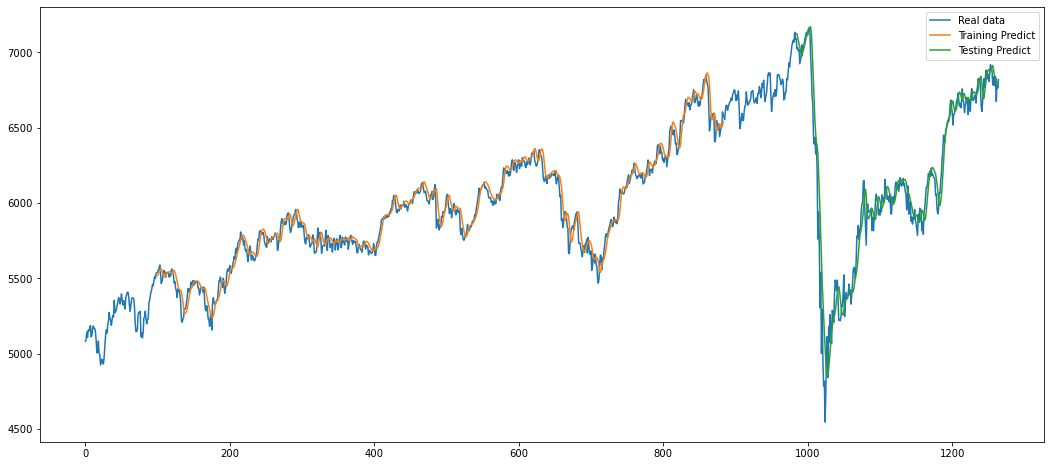

In [30]:
plt.figure(figsize=(18, 8))
# loopBack is time step which we used 100
loopBack = 100 
trainingDataPredictPlot = numpy.empty_like(df_Price_scaled)
trainingDataPredictPlot[: , :] = np.nan
trainingDataPredictPlot[loopBack : len(training_data_predict) +loopBack, :] = training_data_predict

testingDataPredictPlot = numpy.empty_like(df_Price_scaled)
testingDataPredictPlot[: , :] = np.nan
testingDataPredictPlot[len(training_data_predict) +(loopBack*2)+1 : len(df_Price_scaled) -1, :] = test_data_predict

plt.plot(scaler.inverse_transform(df_Price_scaled)) # inverse transform of scaled data
plt.plot(trainingDataPredictPlot)
plt.plot(testingDataPredictPlot)
plt.legend(['Real data', 'Training Predict', 'Testing Predict'])
plt.show()

In [31]:
# Predict future next 30 days 
# and for that take test_data from last 150 days 
# so that it will calculate the next 30 days based on last 150 days
# so that will be len(X_test) - 150
# in this case it will be 230

x_input = test_data[230: ].reshape(1,-1)
x_input.shape

(1, 150)

In [32]:
# convert x_input into list which is from test dataset

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input[:5]

[0.5281099961781002,
 0.5274603852474677,
 0.5700745644945537,
 0.5562009573858204,
 0.571832675329639]

In [33]:
# Next 30 day loop

lst_output = []
n_steps=149
i=0

while(i<30): # loop till i gets to the value of less than 30
    
    if(len(temp_input)>100): # if temp_input is greater than 100. temp_input is the list converted from x_input
        x_input = np.array(temp_input[1:]) 
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1)) # that list results passing into our model and then predict and for that we reshape the x_input
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0]) # get the yhat value 
        
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        
        lst_output.extend(yhat.tolist()) # adding yhat value in final output. As this is a loop the yhat value add into temp_input (temp_input = 101)
        i=i+1


0 day input [0.52746039 0.57007456 0.55620096 0.57183268 0.55753862 0.59782159
 0.60871401 0.60615326 0.59048347 0.60393663 0.58490346 0.60286639
 0.61975926 0.60156698 0.59820378 0.60523604 0.61738961 0.60019106
 0.60393663 0.58390973 0.57882668 0.5378941  0.57985866 0.59873881
 0.52723103 0.53460723 0.55868519 0.50930636 0.5207338  0.50196824
 0.5172941  0.51549773 0.53892608 0.51106447 0.50391745 0.48790373
 0.47318941 0.52661949 0.50827437 0.54228928 0.53747365 0.53739732
 0.48534298 0.50712781 0.47601758 0.53338433 0.54121922 0.56961586
 0.59468756 0.59476407 0.60615326 0.63049883 0.6241927  0.63607866
 0.62327529 0.64337852 0.62625649 0.62900814 0.62212872 0.61952991
 0.61517298 0.57519587 0.57775662 0.54053117 0.52803367 0.53709146
 0.58108156 0.57943822 0.60905794 0.62839679 0.66990247 0.68583986
 0.72757508 0.7155361  0.71056763 0.7407987  0.74611129 0.7586853
 0.7648386  0.76178108 0.7703421  0.80187277 0.8168545  0.79892983
 0.7854386  0.75360207 0.78062297 0.78127277 0.7908

In [34]:
# day_new is 100 indexes
# day_predict only need 30 indexes for 30 future prediction
day_new=np.arange(1,101)
day_predit = np.arange(101,131)

In [35]:
len(df_Price_scaled)

1265

In [36]:
df3=df_Price_scaled.tolist()
df3.extend(lst_output)

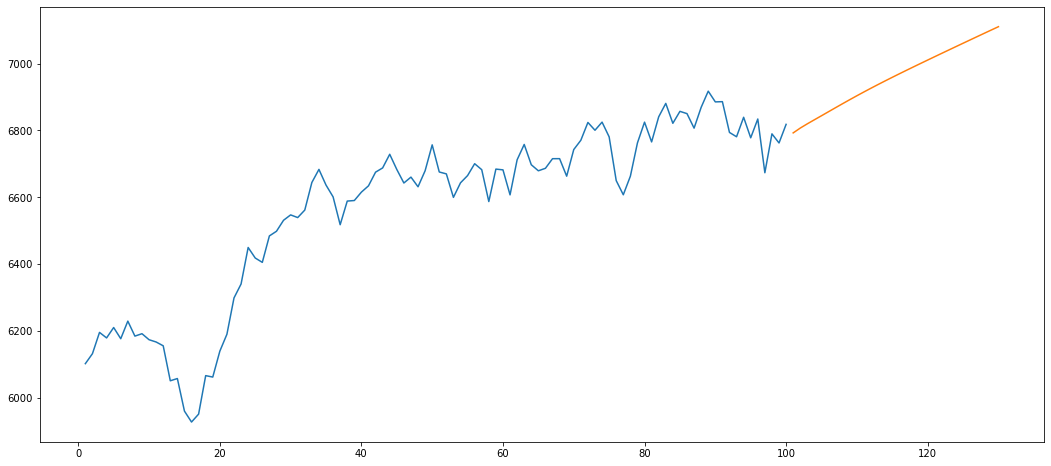

In [37]:
plt.figure(figsize=(18, 8))
plt.plot(day_new, scaler.inverse_transform(df_Price_scaled[1165:])) # real data
plt.plot(day_predit, scaler.inverse_transform(lst_output)) # predict 30 day

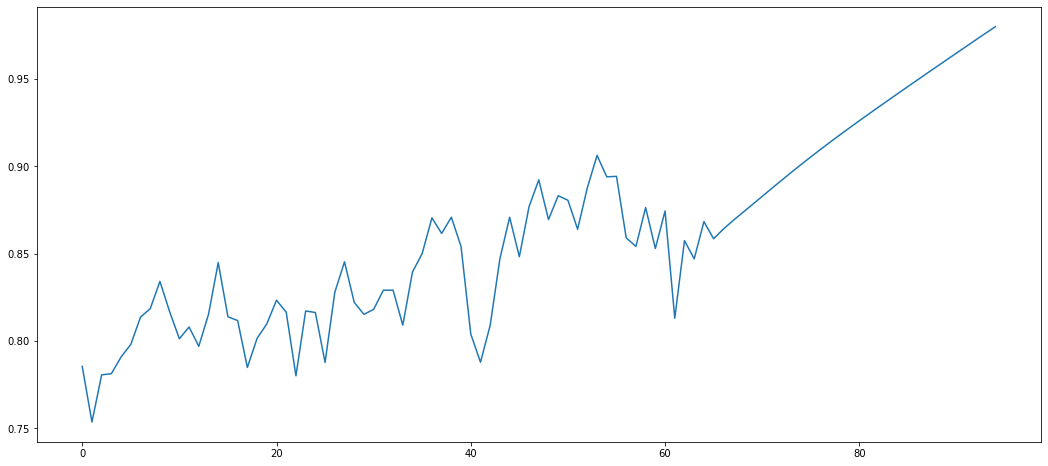

In [38]:
# for complete data 

plt.figure(figsize=(18, 8))
df3=df_Price_scaled.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

---

---